In [1]:
import numpy as np
import pandas as pd
from plotnine import *
import re

C:\ProgramData\Anaconda2\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
from sklearn.metrics import mean_squared_error
from math import sqrt

In [3]:
# load the users and movies data
users = pd.read_table('data/movielens/users.dat',
                      sep='::', header=None, engine='python',
                      names=['user_id', 'gender', 'age', 'occupation', 'zip'])
movies = pd.read_table('data/movielens/movies.dat',
                       sep='::', header=None, engine='python',
                       names=['movie_id', 'title', 'genres'])
ratings = pd.read_table('data/movielens/ratings.dat',
                       sep='::', header=None, engine='python',
                       names=['user_id', 'movie_id', 'rating', 'timestamp'])

In [4]:
users.head()

,user_id,gender,age,occupation,zip
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


In [5]:
movies.head()

,movie_id,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [6]:
print ratings.shape
ratings.head()

(1000209, 4)


,user_id,movie_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [7]:
# some cleaning on movies data
stripbar = lambda x: x.replace('|',' ').replace('-', '') 
movies.loc[:, 'genre'] = movies['genres'].apply(stripbar)
movies.loc[:, 'name'] = movies['title'].apply(lambda x: re.sub('\ \(\d\d\d\d\)', '', x))

In [8]:
# combine the ratings, user, and movie data
ratings_users = pd.merge(ratings, users, how='outer', on='user_id')
data = pd.merge(ratings_users, movies, how='inner', on='movie_id')
data.head()

,user_id,movie_id,rating,timestamp,gender,age,occupation,zip,title,genres,genre,name
0,1,1193,5,978300760,F,1,10,48067,One Flew Over the Cuckoo's Nest (1975),Drama,Drama,One Flew Over the Cuckoo's Nest
1,2,1193,5,978298413,M,56,16,70072,One Flew Over the Cuckoo's Nest (1975),Drama,Drama,One Flew Over the Cuckoo's Nest
2,12,1193,4,978220179,M,25,12,32793,One Flew Over the Cuckoo's Nest (1975),Drama,Drama,One Flew Over the Cuckoo's Nest
3,15,1193,4,978199279,M,25,7,22903,One Flew Over the Cuckoo's Nest (1975),Drama,Drama,One Flew Over the Cuckoo's Nest
4,17,1193,5,978158471,M,50,1,95350,One Flew Over the Cuckoo's Nest (1975),Drama,Drama,One Flew Over the Cuckoo's Nest


In [9]:
# inspect the distribution of ratings per movie
gb_movie = data.groupby('title').agg({'rating': {'rating_count': 'count', 'rating_mean': 'mean'}})
gb_movie.columns = gb_movie.columns.droplevel(0)

C:\ProgramData\Anaconda2\lib\site-packages\pandas\core\groupby.py:4291: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


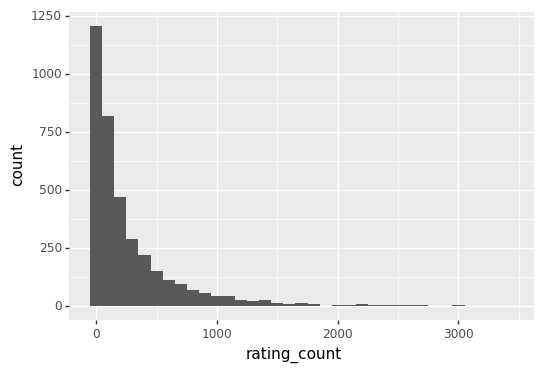

<ggplot: (32396180)>

In [10]:
ggplot(gb_movie) + aes(x='rating_count') + geom_histogram(binwidth=100)

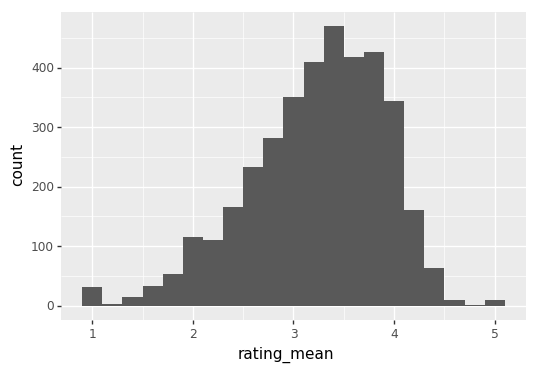

<ggplot: (34098373)>

In [11]:
ggplot(gb_movie) + aes(x='rating_mean') + geom_histogram(binwidth=0.20)

In [12]:
# show 10 highest-rated movies
gb_movie.sort_values('rating_mean', ascending=False).head(10)

,rating_mean,rating_count
title,,
Ulysses (Ulisse) (1954),5.0,1
Lured (1947),5.0,1
Follow the Bitch (1998),5.0,1
Bittersweet Motel (2000),5.0,1
Song of Freedom (1936),5.0,1
One Little Indian (1973),5.0,1
Smashing Time (1967),5.0,2
Schlafes Bruder (Brother of Sleep) (1995),5.0,1
"Gate of Heavenly Peace, The (1995)",5.0,3


In [13]:
# compute mean of all movies
mrating = np.mean(gb_movie['rating_mean'])

In [14]:
q = gb_movie['rating_count'].quantile(0.20)

In [15]:
qmovies = gb_movie.copy().loc[gb_movie['rating_count'] >= q]

In [16]:
print qmovies.shape
qmovies.sort_values('rating_mean', ascending=False).head(10)

(2976, 2)


,rating_mean,rating_count
title,,
Sanjuro (1962),4.608696,69
Seven Samurai (The Magnificent Seven) (Shichinin no samurai) (1954),4.560510,628
"Shawshank Redemption, The (1994)",4.554558,2227
"Godfather, The (1972)",4.524966,2223
"Close Shave, A (1995)",4.520548,657
"Usual Suspects, The (1995)",4.517106,1783
Schindler's List (1993),4.510417,2304
"Wrong Trousers, The (1993)",4.507937,882
Sunset Blvd. (a.k.a. Sunset Boulevard) (1950),4.491489,470


In [17]:
def weight_rating (x, m=mrating, q=q):
    v = x['rating_count']
    r = x['rating_mean']
    return ((v / (v + q)) * r) + ((q / (q + v)) * m)

In [18]:
qmovies['score'] = qmovies.apply(weight_rating, axis=1)

In [19]:
qmovies = qmovies.reset_index()
qmovies = pd.merge(qmovies, movies, how='inner', on='title')
qmovies = qmovies.loc[:, ['title', 'score']]

In [20]:
qmovies.sort_values('score', ascending=False).head(10)

,title,score
2409,"Shawshank Redemption, The (1994)",4.541109
2383,Seven Samurai (The Magnificent Seven) (Shichin...,4.513816
1103,"Godfather, The (1972)",4.511796
2817,"Usual Suspects, The (1995)",4.500828
2356,Schindler's List (1993),4.497849
573,"Close Shave, A (1995)",4.477198
2952,"Wrong Trousers, The (1993)",4.475685
2204,Raiders of the Lost Ark (1981),4.466494
2227,Rear Window (1954),4.449669
2545,Star Wars: Episode IV - A New Hope (1977),4.444424


In [21]:
# filter dataset to include only qualified movies
datasub = data[data['title'].isin(qmovies.title.values)].copy()
# add score to dataset
datasub = pd.merge(datasub, qmovies, how='inner', on='title')
print data.shape, datasub.shape

(1000209, 12) (994103, 13)


In [22]:
datasub.head()

,user_id,movie_id,rating,timestamp,gender,age,occupation,zip,title,genres,genre,name,score
0,1,1193,5,978300760,F,1,10,48067,One Flew Over the Cuckoo's Nest (1975),Drama,Drama,One Flew Over the Cuckoo's Nest,4.375569
1,2,1193,5,978298413,M,56,16,70072,One Flew Over the Cuckoo's Nest (1975),Drama,Drama,One Flew Over the Cuckoo's Nest,4.375569
2,12,1193,4,978220179,M,25,12,32793,One Flew Over the Cuckoo's Nest (1975),Drama,Drama,One Flew Over the Cuckoo's Nest,4.375569
3,15,1193,4,978199279,M,25,7,22903,One Flew Over the Cuckoo's Nest (1975),Drama,Drama,One Flew Over the Cuckoo's Nest,4.375569
4,17,1193,5,978158471,M,50,1,95350,One Flew Over the Cuckoo's Nest (1975),Drama,Drama,One Flew Over the Cuckoo's Nest,4.375569


In [23]:
# take smaller subset for speed reasons
datasub = datasub.loc[np.random.choice(datasub.index, size=250000, replace=False), :]

In [26]:
users_more4 = pd.value_counts(datasub.user_id, sort=False) > 4
users_more4 = users_more4[users_more4].index

datasub = datasub.loc[datasub.index.map(lambda x: datasub.loc[x, 'user_id'] in users_more4)]
print datasub.shape
assert np.all(datasub.user_id.value_counts() > 4)

(249273, 13)


In [27]:
# count number of movies for each user
datasub['user_count'] = datasub.groupby('user_id')['rating'].transform('count')
pfunc = lambda x: np.percentile((range(0, len(x))), 80).astype(int)
datasub['user_p80'] = datasub.groupby('user_id')['rating'].transform(pfunc)
datasub = datasub.sort_values(['user_id', 'timestamp'], ascending=True)

In [28]:
datasub['rowi'] = 1
datasub['user_order'] = datasub.groupby('user_id')['rowi'].transform('cumsum')
datasub['test'] = datasub['user_order'] > datasub['user_p80']

In [29]:
datasub = datasub.drop(['user_count', 'user_p80', 'rowi', 'user_order'], axis=1)
datasub.head()

,user_id,movie_id,rating,timestamp,gender,age,occupation,zip,title,genres,genre,name,score,test
23270,1,1270,5,978300055,F,1,10,48067,Back to the Future (1985),Comedy|Sci-Fi,Comedy SciFi,Back to the Future,3.983689,False
37339,1,1022,5,978300055,F,1,10,48067,Cinderella (1950),Animation|Children's|Musical,Animation Children's Musical,Cinderella,3.735824,False
51327,1,1207,4,978300719,F,1,10,48067,To Kill a Mockingbird (1962),Drama,Drama,To Kill a Mockingbird,4.396945,False
8926,1,2804,5,978300719,F,1,10,48067,"Christmas Story, A (1983)",Comedy|Drama,Comedy Drama,"Christmas Story, A",4.222178,False
22832,1,720,3,978300760,F,1,10,48067,Wallace & Gromit: The Best of Aardman Animatio...,Animation,Animation,Wallace & Gromit: The Best of Aardman Animation,4.367667,False


In [30]:
test = datasub[datasub['test']]

In [31]:
train = datasub[~datasub['test']]

In [32]:
len(test['movie_id'].unique())

2936

In [33]:
len(train['movie_id'].unique())

2974

In [34]:
# remove from train ratings of movies not in test
# will need same size user-item matrix in train and test
test_items = test['movie_id'].unique()
train = train[train['movie_id'].isin(test_items)]
# and vice versa
train_items = train['movie_id'].unique()
test = test[test['movie_id'].isin(train_items)]

In [35]:
len(train['movie_id'].unique()) == len(test['movie_id'].unique())

True

# Mini-Challenge prep: evaluation functions

These are the two functions that you will need to test your `estimate` method.

In [292]:
def evaluate(rec_func, testdata):
    """ RMSE-based predictive performance evaluation with pandas. """
    test = testdata
    ids_to_estimate = zip(test.user_id, test.movie_id)
    ypred = np.array([rec_func(u,i) for (u,i) in ids_to_estimate])
    ytrue = test.rating.values
    return sqrt(mean_squared_error(ypred, ytrue))

### 1. Simple collaborative filter using global mean rating

In [113]:
# get dataset of global mean
global_mean = train['rating'].mean()

In [114]:
def alg_mean(user_id, movie_id):
    """ Simple collaborative-filter based on mean ratings. 
    Return mean rating of movie from training set.
    """
    return global_mean

In [115]:
print 'RMSE: %s' % evaluate(alg_mean)

RMSE: 1.14843300664


### 1. Simple collaborative filter - movie mean ratings

In [116]:
# get dataset of global means of training set movies
movie_means = train.groupby('movie_id')['rating'].mean()

In [117]:
def alg_means(user_id, movie_id):
    """ Simple collaborative-filter based on mean ratings. 
    Return mean rating of movie from training set.
    """
    return movie_means.loc[movie_id]

In [118]:
print 'RMSE: %s' % evaluate(alg_means)

RMSE: 1.0038696568


### 2. Simple collaborative filter - user and movie means

In [134]:
user_means = train.groupby('user_id')['rating'].mean()

In [135]:
user_means_adj = user_means - global_mean
movie_means_adj = movie_means - global_mean

In [130]:
def alg_adjust(user_id, movie_id):
    """ Simple collaborative-filter based on mean ratings. 
    Return mean rating of movie from training set.
    """
    user_adjust = user_means_adj.loc[user_id]
    movie_adjust = movie_means_adj.loc[movie_id]
    return global_mean + user_adjust + movie_adjust
    

In [131]:
print 'RMSE: %s' % evaluate(alg_adjust)

RMSE: 0.977076156865


### Simple collaborative filter - Gender and age

In [138]:
train.head()

,user_id,movie_id,rating,timestamp,gender,age,occupation,zip,title,genres,genre,name,score,test
23270,1,1270,5,978300055,F,1,10,48067,Back to the Future (1985),Comedy|Sci-Fi,Comedy SciFi,Back to the Future,3.983689,False
37339,1,1022,5,978300055,F,1,10,48067,Cinderella (1950),Animation|Children's|Musical,Animation Children's Musical,Cinderella,3.735824,False
51327,1,1207,4,978300719,F,1,10,48067,To Kill a Mockingbird (1962),Drama,Drama,To Kill a Mockingbird,4.396945,False
8926,1,2804,5,978300719,F,1,10,48067,"Christmas Story, A (1983)",Comedy|Drama,Comedy Drama,"Christmas Story, A",4.222178,False
22832,1,720,3,978300760,F,1,10,48067,Wallace & Gromit: The Best of Aardman Animatio...,Animation,Animation,Wallace & Gromit: The Best of Aardman Animation,4.367667,False


In [149]:
gb = train.groupby(['age', 'gender', 'movie_id'])['rating'].mean()

In [152]:
gbwide = gb.unstack()

In [162]:
gbwide.head(10)

movie_id        1         2         3         4         5         6     \
age gender                                                               
1   F       4.200000  4.000000  4.000000  2.720000  4.000000  3.821782   
    M       4.230769  3.000000  2.000000  2.720000  4.000000  3.666667   
18  F       4.000000  3.000000  2.200000  3.666667  2.166667  3.888889   
    M       4.000000  3.095238  3.611111  1.500000  2.888889  4.029412   
25  F       4.290323  3.100000  3.500000  2.600000  3.250000  4.000000   
    M       4.176056  2.976744  3.200000  3.000000  2.866667  3.946667   
35  F       4.176471  3.428571  2.833333  3.000000  3.750000  3.272727   
    M       4.285714  3.555556  2.846154  2.000000  2.000000  3.516129   
45  F       4.000000  3.142857  3.112360  2.720000  4.000000  4.000000   
    M       4.100000  3.600000  3.666667  2.720000  3.000000  3.750000   

movie_id        7         8         9         10      ...         3942  \
age gender                                            ...                
1   F       3.414894  3.000000  2.866667  3.473988    ...     1.857143   
    M       3.414894  2.823529  2.866667  3.700000    ...     1.857143   
18  F       3.714286  2.000000  3.000000  3.800000    ...     1.857143   
    M       3.400000  2.400000  3.000000  3.593750    ...     2.000000   
25  F       3.450000  3.000000  2.866667  3.666667    ...     1.000000   
    M       3.210526  2.500000  2.625000  3.308824    ...     2.000000   
35  F       3.500000  3.500000  2.866667  2.800000    ...     1.857143   
    M       3.800000  3.000000  3.333333  3.631579    ...     3.000000   
45  F       3.000000  2.823529  2.866667  4.000000    ...     1.857143   
    M       3.400000  3.000000  2.866667  3.727273    ...     1.857143   

movie_id        3943  3945      3946      3947      3948      3949  3950  \
age gender                                                                 
1   F       2.545455   1.4  2.166667  3.625000  4.500000  4.066667   4.0   
    M       2.000000   1.4  2.166667  3.625000  4.111111  4.066667   5.0   
18  F       4.000000   1.0  2.166667  3.625000  3.285714  4.000000   3.0   
    M       2.666667   2.0  2.800000  3.625000  4.076923  4.200000   1.5   
25  F       2.000000   1.4  1.000000  3.625000  4.000000  2.666667   3.0   
    M       1.500000   1.0  2.000000  4.333333  3.529412  4.555556   2.0   
35  F       4.000000   1.4  2.000000  3.625000  3.230769  2.000000   3.0   
    M       3.000000   1.4  1.666667  4.000000  4.071429  4.666667   3.0   
45  F       2.545455   1.4  2.166667  4.000000  4.000000  4.066667   3.0   
    M       2.545455   1.4  1.000000  1.000000  4.000000  5.000000   3.0   

movie_id    3951      3952  
age gender                  
1   F        3.0  3.785714  
    M        3.0  3.333333  
18  F        3.0  4.000000  
    M        3.0  3.500000  
25  F        2.0  4.400000  
    M        3.0  3.900000  
35  F        3.0  3.250000  
    M        4.0  3.833333  
45  F        5.0  4.000000  
    M        1.0  3.500000  

[10 rows x 2934 columns]

In [161]:
# fill missing with movie global mean

for c in gbwide.columns:
    gbwide.loc[:, c] = gbwide.loc[:, c].fillna(movie_means.loc[c])


In [170]:
users = users.set_index('user_id')

In [173]:
ix = (1, 'F')
ix

(1, 'F')

In [176]:
def alg_gender_age(user_id, movie_id):
    """ Simple collaborative-filter based on mean ratings. 
    Return mean rating of movie from training set.
    """
    gender = users.loc[user_id, 'gender']
    age = users.loc[user_id, 'age']
    idx = (age, gender)
    return gbwide.loc[idx, movie_id]

In [177]:
print 'RMSE: %s' % evaluate(alg_gender_age)

RMSE: 1.0658075723


### Simple collaborative filter - Similar users

In [179]:
from sklearn.decomposition import NMF
from sklearn.preprocessing import Normalizer, MaxAbsScaler
from sklearn.pipeline import make_pipeline

In [180]:
sppt = train.pivot_table('rating', index='user_id', columns='movie_id', fill_value=0)

In [182]:
scaler = MaxAbsScaler()
normalizer = Normalizer()

In [199]:
nmf = NMF(n_components=100)

In [213]:
pipeline = make_pipeline(scaler, nmf, normalizer)
norm_features = pipeline.fit_transform(sppt)

In [214]:
from sklearn.metrics.pairwise import pairwise_distances
user_sim = pairwise_distances(norm_features, metric='cosine')

In [215]:
user_sim_df = pd.DataFrame(user_sim, index=user_means.index, columns=user_means.index)

In [282]:
# create dict where key is movie and value is list of raters
movie_raters = train.groupby('movie_id')['user_id'].apply(list).to_dict()

In [ ]:
train_um = train.set_index(['user_id', 'movie_id'])

In [289]:
def alg_similar_20(user_id, movie_id):
    """ Simple collaborative-filter based user similarities. 
    Return mean rating of movie from users most similar, up to 20).
    """
    # get ids of training set raters
    train_raters = movie_raters[movie_id]
    # get the 20 most similar raters of movie
    most_sim = np.array(user_sim_df[user_id][train_raters].nlargest(20).index)
    # set index
    ix = zip(most_sim, [movie_id] * len(most_sim))
    return train_um.loc[ix, 'rating'].mean()

In [309]:
print 'RMSE: %s' % evaluate(alg_similar_20, test)

RMSE: 1.03798523551


In [355]:
def alg_similar(user_id, movie_id):
    """ Simple collaborative-filter based user similarities. 
    Return mean rating of movie from users most similar, up to 20).
    """
    train_raters = movie_raters[movie_id]
    sim_scores = np.array(user_sim_df[user_id][train_raters])
    rater_means = user_means[train_raters]
    ix = zip(train_raters, [movie_id] * len(train_raters))
    rater_scores = train_um.loc[ix, 'rating']
    user_mean = user_means[user_id]
    den = np.sum(sim_scores)
    num = np.sum(sim_scores * (rater_scores - rater_means))
    return user_mean + (num/den)

In [358]:
print 'RMSE: %s' % evaluate(alg_similar, test)

RMSE: 0.976771322467


In [67]:
from surprise import SVD
from surprise import Dataset
from surprise import Reader
from surprise import NormalPredictor
from surprise.model_selection import cross_validate
from surprise import accuracy

In [45]:
data_train = train.loc[:, ['user_id', 'movie_id', 'rating']]
data_test = test.loc[:, ['user_id', 'movie_id', 'rating']]

In [46]:
reader = Reader(rating_scale=(1, 5))
dftrain = Dataset.load_from_df(data_train, reader)
dftest = Dataset.load_from_df(data_test, reader)

In [52]:
cross_validate(NormalPredictor(), dftrain, cv=2)

{u'fit_time': (0.09999990463256836, 0.0989999771118164),
 u'test_mae': array([ 1.19656503,  1.19504292]),
 u'test_rmse': array([ 1.49403483,  1.49350161]),
 u'test_time': (0.6080000400543213, 0.6070001125335693)}

In [53]:
cross_validate(SVD(), dftrain, cv=2)

{u'fit_time': (5.205000162124634, 5.388000011444092),
 u'test_mae': array([ 0.7487613,  0.7477967]),
 u'test_rmse': array([ 0.94440088,  0.94506263]),
 u'test_time': (0.8799998760223389, 0.8380000591278076)}

In [62]:
trainset = dftrain.build_full_trainset()
testset = dftest.build_full_trainset()
testset = testset.build_testset()

In [77]:
# We'll use the famous SVD algorithm.
algo = SVD()

# Train the algorithm on the trainset, and predict ratings for the testset
algo.fit(trainset)
predictions = algo.test(testset)

In [78]:
accuracy.rmse(predictions, verbose=True)

RMSE: 0.9566


0.95656611782335121

In [76]:
from surprise import BaselineOnly
algo = BaselineOnly()
algo.fit(trainset)
predictions = algo.test(testset)
print accuracy.rmse(predictions)

Estimating biases using als...
RMSE: 0.9518
0.95176887223


## 2.  Simple collaborative filtering using weighted score

In [302]:
def collab_wscore(user_id, movie_id):
    """ Simple collaborative-filtering based on weighted score. 
    Return mean weighted score of test movie from all other users.
    """
    movie_condition = train.movie_id == movie_id
    weighted_scores = train.loc[movie_condition]
    weighted_scores = weighted_scores.loc[:, 'score']
    
    if weighted_scores.empty:
        score = 3.0
    else:
        score =  weighted_scores.iloc[0]
    
    return score

In [ ]:
print 'RMSE: %s' % evaluate(collab_wscore)

In [309]:
def collab_gender_age(user_id, movie_id):
    """ 
    Collaborative filtering using gender and age. 
    Use weighted score.
    """
    
    user_condition = train.user_id != user_id
    movie_condition = train.movie_id == movie_id
    ratings_by_others = train.loc[user_condition & movie_condition]
    
    if ratings_by_others.empty: 
        return 3.0
    
    pt = ratings_by_others.pivot_table('score', index='movie_id', columns=['gender', 'age'])
    user_info = users.set_index('user_id')
    user_gender = user_info.loc[user_id, 'gender']
    user_age = user_info.loc[user_id, 'age']
    gender_age = (user_gender, user_age)
    
    if gender_age in pt.columns: 
        if np.isnan(pt.loc[movie_id, gender_age]):
            return pt.loc[movie_id, user_gender].mean() 
        else:
            return pt.loc[movie_id, gender_age]
    else:
        return pt.loc[movie_id].mean()

In [310]:
print 'RMSE: %s' % evaluate(collab_gender_age)

RMSE: 0.971788297512


In [82]:
from sklearn.feature_extraction.text import CountVectorizer

In [83]:
vectorizer = CountVectorizer(input='content')

In [123]:
dtm = vectorizer.fit_transform(movies['genre'])

In [124]:
vocab = vectorizer.get_feature_names()

In [125]:
dtm = dtm.toarray()

In [126]:
vocab = np.array(vocab)

In [127]:
dtm_5 = dtm[0:5, :]
dtm_5_index = movies['title']
dtm_5_index = dtm_5_index.iloc[0:5]
pd.DataFrame(dtm_5, columns=vocab, index=dtm_5_index)

,action,adventure,animation,children,comedy,crime,documentary,drama,fantasy,filmnoir,horror,musical,mystery,romance,scifi,thriller,war,western
title,,,,,,,,,,,,,,,,,,
Toy Story (1995),0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
Jumanji (1995),0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
Grumpier Old Men (1995),0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
Waiting to Exhale (1995),0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
Father of the Bride Part II (1995),0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [159]:
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import NMF
from sklearn.preprocessing import normalize

In [135]:
model = NMF(n_components=10)
model.fit(dtm)

NMF(alpha=0.0, beta_loss='frobenius', init=None, l1_ratio=0.0, max_iter=200,
  n_components=10, random_state=None, shuffle=False, solver='cd',
  tol=0.0001, verbose=0)

In [136]:
nmf_features = model.transform(dtm)

In [137]:
nmf_features[0, :]

array([ 0.        ,  0.17792112,  0.        ,  0.00036548,  0.        ,
        0.        ,  0.29722762,  0.        ,  0.        ,  0.        ])

In [139]:
df = pd.DataFrame(nmf_features, index=movies['name'])

In [140]:
print df.loc['Beauty and the Beast']
print df.loc['Aladdin']

0    0.000000
1    0.000789
2    0.000000
3    0.000253
4    0.004256
5    0.000566
6    0.353689
7    0.000000
8    0.000000
9    0.000000
Name: Beauty and the Beast, dtype: float64
0    0.000000
1    0.179251
2    0.000000
3    0.000202
4    0.004197
5    0.000560
6    0.352805
7    0.000000
8    0.000000
9    0.000000
Name: Aladdin, dtype: float64


In [143]:
print(model.components_.shape)

(10L, 18L)


In [144]:
pd.DataFrame(model.components_, columns=vocab)

,action,adventure,animation,children,comedy,crime,documentary,drama,fantasy,filmnoir,horror,musical,mystery,romance,scifi,thriller,war,western
0,0.000000,0.000000,0.000000,0.001834,0.000000,0.000000,0.016204,7.273418,0.002952,0.000000,0.000000,0.000000,0.053438,0.00000,0.000000,0.000000,0.294008,0.037709
1,0.000000,0.000000,0.000000,0.010685,5.602094,0.000000,0.018052,0.000000,0.007801,0.000000,0.000000,0.046940,0.012384,0.00000,0.000000,0.000000,0.000000,0.071244
2,5.723545,0.006228,0.000000,0.000000,0.000000,0.000432,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.009650,0.634408,0.104627
3,0.008027,0.002936,0.026809,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.161390,0.000000,0.000000,0.524049,0.00000,0.000210,4.593133,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.020918,0.000000,0.000000,0.168712,0.071699,4.90207,0.000000,0.000000,0.108290,0.000000
5,0.003000,0.001365,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.869521,0.021276,0.000000,0.00000,0.000279,0.001668,0.000000,0.000000
6,0.000000,0.000000,1.824203,3.754242,0.000000,0.000000,0.002205,0.000000,0.454578,0.003993,0.000000,1.040904,0.019941,0.00000,0.000000,0.000000,0.006339,0.000000
7,0.000000,0.000000,0.008792,0.000000,0.000000,0.000000,0.000000,0.000000,0.061108,0.000000,0.000000,0.000000,0.000000,0.00000,3.857162,0.001694,0.000000,0.005165
8,0.017246,0.000000,0.000000,0.000000,0.000000,3.984213,0.000000,0.006114,0.000000,0.308234,0.000000,0.000000,0.191561,0.00000,0.000000,0.000000,0.000000,0.000000
9,0.006913,3.702984,0.000000,0.205002,0.000000,0.000000,0.000000,0.000000,0.422182,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.012967


In [155]:
df_components = pd.DataFrame(model.components_, columns=vocab)
component_0 = df_components.iloc[0, :]
print component_0.nlargest()

drama          7.273418
war            0.294008
mystery        0.053438
western        0.037709
documentary    0.016204
Name: 0, dtype: float64


In [157]:
nmf_features.shape

(3883L, 10L)

In [160]:
norm_features = normalize(nmf_features)

In [161]:
df = pd.DataFrame(norm_features, index=movies['name'])

In [166]:
df.shape

(3883, 10)

In [168]:
movie = df.loc["Toy Story"]
similarities = df.dot(movie)
print(similarities.nlargest())

name
Toy Story                              1.0
Aladdin and the King of Thieves        1.0
American Tail, An                      1.0
American Tail: Fievel Goes West, An    1.0
Rugrats Movie, The                     1.0
dtype: float64


In [147]:
df.sort_values(9, ascending=False).head(10)

,0,1,2,3,4,5,6,7,8,9
name,,,,,,,,,,
"NeverEnding Story III, The",0.000034,0.0,0.0,0.0,0.0,0.0,0.209686,0.002974,0.0,0.296318
"NeverEnding Story, The",0.000034,0.0,0.0,0.0,0.0,0.0,0.209686,0.002974,0.0,0.296318
Jumanji,0.000034,0.0,0.0,0.0,0.0,0.0,0.209686,0.002974,0.0,0.296318
Kids of the Round Table,0.000034,0.0,0.0,0.0,0.0,0.0,0.209686,0.002974,0.0,0.296318
"Indian in the Cupboard, The",0.000034,0.0,0.0,0.0,0.0,0.0,0.209686,0.002974,0.0,0.296318
Santa Claus: The Movie,0.000034,0.0,0.0,0.0,0.0,0.0,0.209686,0.002974,0.0,0.296318
Escape to Witch Mountain,0.000034,0.0,0.0,0.0,0.0,0.0,0.209686,0.002974,0.0,0.296318
"NeverEnding Story II: The Next Chapter, The",0.000034,0.0,0.0,0.0,0.0,0.0,0.209686,0.002974,0.0,0.296318
Labyrinth,0.000034,0.0,0.0,0.0,0.0,0.0,0.209686,0.002974,0.0,0.296318


In [175]:
spt = train.pivot_table('rating', index='movie_id', columns=['user_id'], fill_value=0)

In [177]:
train.rating.unique()

array([5, 4, 3, 1, 2], dtype=int64)

In [176]:
spt.head(5)

user_id,1,2,3,4,5,6,8,9,10,11,...,6031,6032,6033,6034,6035,6036,6037,6038,6039,6040
movie_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,2,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [167]:
from sklearn.decomposition import NMF
from sklearn.preprocessing import Normalizer, MaxAbsScaler
from sklearn.pipeline import make_pipeline

In [179]:
sppt = train.pivot_table('rating', index='name', columns='user_id', fill_value=0)

In [180]:
scaler = MaxAbsScaler()
nmf = NMF(n_components=20)
normalizer = Normalizer()
pipeline = make_pipeline(scaler, nmf, normalizer)
norm_features = pipeline.fit_transform(sppt)

In [181]:
norm_features.shape

(2897L, 20L)

In [183]:
df = pd.DataFrame(norm_features, index=sppt.index)
movie = df.loc["Toy Story"]
similarities = df.dot(movie)
print(similarities.nlargest())

name
Toy Story                      1.000000
Muppets Take Manhattan, The    0.981802
Clue                           0.975218
Great Muppet Caper, The        0.971666
Joe's Apartment                0.966464
dtype: float64


In [209]:
matdf_train = train.pivot_table('rating', index='user_id', columns=['movie_id'], fill_value=0)
matdf_test = test.pivot_table('rating', index='user_id', columns=['movie_id'], fill_value=0)
mat_train = np.array(matdf_train)
mat_test = np.array(matdf_test)

In [210]:
print mat_train.shape, mat_test.shape

(5814L, 2935L) (5814L, 2935L)


In [211]:
from sklearn.metrics.pairwise import pairwise_distances
user_sim = pairwise_distances(mat_train, metric='cosine')
item_sim= pairwise_distances(mat_train.T, metric='cosine')

In [212]:
def predict(ratings, similarity, type='user'):
    if type == 'user':
        mean_user_rating = ratings.mean(axis=1)
        #You use np.newaxis so that mean_user_rating has same format as ratings
        ratings_diff = (ratings - mean_user_rating[:, np.newaxis])
        pred = mean_user_rating[:, np.newaxis] + similarity.dot(ratings_diff) / np.array([np.abs(similarity).sum(axis=1)]).T
    elif type == 'item':
        pred = ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])
    return pred

In [213]:
item_prediction = predict(mat_train, item_sim, type='item')
user_prediction = predict(mat_train, user_sim, type='user')

In [238]:
pd.Series(user_sim[3, :]).describe()

count    5814.000000
mean        0.980898
std         0.047402
min         0.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         1.000000
dtype: float64

In [215]:
user_prediction.shape

(5814L, 2935L)

In [216]:
def rmse(prediction, test_data):
    prediction = prediction[test_data.nonzero()].flatten()
    test_data = test_data[test_data.nonzero()].flatten()
    return sqrt(mean_squared_error(prediction, test_data))

In [217]:
print 'User-based CF RMSE: ' + str(rmse(user_prediction, mat_test))
print 'Item-based CF RMSE: ' + str(rmse(item_prediction, mat_test))

User-based CF RMSE: 3.5177405248
Item-based CF RMSE: 3.57147277659


In [218]:
preds_1 = item_prediction[mat_test.nonzero()].flatten()

In [221]:
test['pred0'] = preds_0
test['pred1'] = preds_1

In [227]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [106]:
user_prediction.shape

(5814L, 2975L)